<a href="https://colab.research.google.com/github/niqolla/dmi_2/blob/main/I_Think_This_Works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.patches import Patch


In [ ]:
# read human data
human_data = pd.read_csv("/content/drive/MyDrive/datasets/human.gct", sep="\t", skiprows=2, )
mouse_data = pd.read_csv("/content/drive/MyDrive/datasets/mouse.txt",sep="\t")
rat_data = pd.read_csv("/content/drive/MyDrive/datasets/rat.txt",sep="\t")
species_ids = pd.read_csv("/content/drive/MyDrive/mart_ids.txt", sep="\t", na_values=[""])



In [ ]:
human_data = human_data.set_index('Name')

In [ ]:
to_keep = ["colon", "ileum", "duodenum", "jejunum", "small intestine" ,\
               "muscle", "pancreas", "liver", "stomach",  "kidney",  "quadriceps", \
               "thymus", "heart" , "esophagus", "brain", "gene_symbol_human"]

for i in human_data:
  if not any(cat in i.lower().split(' ') for cat in to_keep): 
               human_data.drop(columns=[i], inplace = True)

# Exercise 1

### PREPROCESSING

#### Scaling data

In [ ]:
# SCALING MOUSE
mouse_index = mouse_data.index
scaler = StandardScaler()
mouse_data = pd.DataFrame(scaler.fit_transform(mouse_data), columns=mouse_data.columns+"___MOUSE")
mouse_data.index = mouse_index

In [ ]:
# SCALING RAT
rat_index = rat_data.index
scaler = StandardScaler()
rat_data = pd.DataFrame(scaler.fit_transform(rat_data), columns=rat_data.columns+"___RAT")
rat_data.index = rat_index

In [ ]:
# SCALING HUMAN
human_index = human_data.index
scaler = StandardScaler()
human_data = pd.DataFrame(scaler.fit_transform(human_data), columns=human_data.columns+"___HUMAN")
human_data.index = human_index

#### Removing dulicates

In [ ]:
# REMOVING DUPLICATES
human_data.drop_duplicates(inplace=True)
mouse_data.drop_duplicates(inplace=True)
rat_data.drop_duplicates(inplace=True)

In [ ]:
# there are no duplicated columns
print(human_data.T.duplicated().sum())
print(mouse_data.T.duplicated().sum())
print(rat_data.T.duplicated().sum())

0
0
0


In [ ]:
print(human_data.shape)
print(mouse_data.shape)
print(rat_data.shape)

(38192, 27)
(34640, 39)
(24044, 40)


#### Organising tables

In [ ]:
#### CREATING TABLE : index gene_symbol_human 	gene_symbol_mouse 	gene_symbol_rat
species_ids = species_ids.iloc[:, [1, 4, 5]]
species_ids = species_ids.dropna()
species_ids.columns = ["gene_symbol_human", "gene_symbol_mouse", "gene_symbol_rat"]

In [ ]:
#### CREATING TABLE : index || gene_symbol_mouse  |	199_1_Pancreas  |	 199_2_Liver  |	 199_3_Stomach .... (keeping only columns of interest)
human_data = human_data.reset_index().rename(columns={'Name':"gene_symbol_human"})

#### CREATING TABLE : gene_symbol_mouse 	199_1_Pancreas 	199_2_Liver 	199_3_Stomach ...
mouse_data = mouse_data.reset_index().rename(columns={'index': 'gene_symbol_mouse'})
# mouse_data

#### CREATING TABLE : gene_symbol_rat 	199_40_Pancreas 	199_41_Liver ....
rat_data = rat_data.reset_index().rename(columns={'index': 'gene_symbol_rat'})
# rat_data

In [ ]:
display(human_data.head(5))
display(mouse_data.head(5))
display(rat_data.head(5))

,gene_symbol_human,Brain - Amygdala___HUMAN,Brain - Anterior cingulate cortex (BA24)___HUMAN,Brain - Caudate (basal ganglia)___HUMAN,Brain - Cerebellar Hemisphere___HUMAN,Brain - Cerebellum___HUMAN,Brain - Cortex___HUMAN,Brain - Frontal Cortex (BA9)___HUMAN,Brain - Hippocampus___HUMAN,Brain - Hypothalamus___HUMAN,...,Esophagus - Muscularis___HUMAN,Heart - Atrial Appendage___HUMAN,Heart - Left Ventricle___HUMAN,Kidney - Cortex___HUMAN,Kidney - Medulla___HUMAN,Liver___HUMAN,Muscle - Skeletal___HUMAN,Pancreas___HUMAN,Small Intestine - Terminal Ileum___HUMAN,Stomach___HUMAN
0,ENSG00000223972.5,-0.021067,-0.022600,-0.022567,-0.038158,-0.035234,-0.024565,-0.026760,-0.020814,-0.022961,...,-0.038661,-0.024941,-0.021577,-0.021645,-0.025209,-0.028215,-0.030899,-0.022970,-0.035624,-0.029976
1,ENSG00000227232.5,-0.019289,-0.020369,-0.020514,-0.027047,-0.023602,-0.021058,-0.023432,-0.018762,-0.020570,...,-0.029286,-0.022688,-0.020404,-0.017946,-0.021908,-0.025102,-0.028260,-0.020444,-0.026077,-0.023897
2,ENSG00000243485.5,-0.021067,-0.022600,-0.022535,-0.038158,-0.035234,-0.024526,-0.026713,-0.020814,-0.022927,...,-0.038661,-0.024941,-0.021555,-0.021622,-0.025209,-0.028215,-0.030899,-0.022970,-0.035624,-0.029976
3,ENSG00000268020.3,-0.021006,-0.022529,-0.022507,-0.038103,-0.035159,-0.024504,-0.026695,-0.020750,-0.022907,...,-0.038661,-0.024887,-0.021512,-0.021593,-0.025209,-0.028157,-0.030829,-0.022970,-0.035544,-0.029911
4,ENSG00000240361.1,-0.020988,-0.022510,-0.022473,-0.038054,-0.035133,-0.024465,-0.026647,-0.020720,-0.022873,...,-0.038563,-0.024852,-0.021485,-0.021568,-0.025209,-0.028139,-0.030798,-0.022970,-0.035534,-0.029882


,gene_symbol_mouse,199_1_Pancreas___MOUSE,199_2_Liver___MOUSE,199_3_Stomach___MOUSE,199_4_Duodenum___MOUSE,199_5_Jejunum___MOUSE,199_6_Ileum___MOUSE,199_7_Colon___MOUSE,199_8_Kidney___MOUSE,199_9_Quadriceps___MOUSE,...,199_30_Duodenum___MOUSE,199_31_Jejunum___MOUSE,199_32_Ileum___MOUSE,199_33_Colon___MOUSE,199_34_Kidney___MOUSE,199_35_Quadriceps___MOUSE,199_36_Thymus___MOUSE,199_37_Heart___MOUSE,199_38_Esophagus___MOUSE,199_39_Brain___MOUSE
0,ENSMUSG00000000001,-0.014148,0.100468,0.037376,0.352963,0.527822,0.475515,0.626422,0.130690,-0.011926,...,0.247006,0.498767,0.237501,0.528208,0.103836,-0.009230,1.347310,-0.000172,0.359503,0.077211
1,ENSMUSG00000000003,-0.018709,-0.055295,-0.021666,-0.081032,-0.086127,-0.059254,-0.121411,-0.048419,-0.039340,...,-0.075969,-0.088490,-0.040180,-0.120699,-0.044077,-0.034835,-0.185073,-0.039470,-0.088664,-0.130549
2,ENSMUSG00000000028,-0.018616,-0.052355,-0.017735,-0.056296,-0.057793,-0.018018,-0.033238,-0.042337,-0.034189,...,-0.050698,-0.042767,-0.020646,-0.063786,-0.041081,-0.030445,0.397206,-0.034466,-0.068726,-0.119410
3,ENSMUSG00000000031,-0.017873,-0.055037,-0.020505,-0.080516,-0.085197,-0.058281,-0.120640,-0.048311,1.057909,...,-0.073892,-0.081972,-0.037917,-0.108093,-0.040266,1.614759,-0.019894,-0.015597,6.531937,-0.121136
4,ENSMUSG00000000037,-0.018709,-0.055295,-0.021464,-0.080014,-0.085777,-0.057314,-0.105695,-0.047524,-0.039019,...,-0.075189,-0.083029,-0.039680,-0.096480,-0.043287,-0.034225,-0.175600,-0.038334,-0.079250,-0.122464


,gene_symbol_rat,199_40_Pancreas___RAT,199_41_Liver___RAT,199_42_Stomach___RAT,199_43_Duodenum___RAT,199_44_Jejunum___RAT,199_45_Ileum___RAT,199_46_Colon___RAT,199_47_Kidneys___RAT,199_48_Quadriceps___RAT,...,199_70_Jejunum___RAT,199_71_Ileum___RAT,199_72_Colon___RAT,199_73_Kidneys___RAT,199_74_Quadriceps___RAT,199_75_Thymus___RAT,199_76_Heart___RAT,199_77_Esophagus___RAT,199_78_Brain___RAT,199_79_Unknown___RAT
0,ENSRNOG00000000001,-0.023467,-0.055063,-0.022609,-0.066521,-0.077879,-0.064507,-0.061412,-0.062767,-0.044383,...,-0.079536,-0.114682,-0.079361,-0.051383,-0.041018,-0.155432,-0.037982,-0.075423,-0.085802,-0.015804
1,ENSRNOG00000000007,-0.023246,-0.055119,-0.023498,-0.067812,-0.079283,-0.067083,-0.067312,-0.062996,-0.044841,...,-0.081783,-0.127999,-0.087342,-0.051761,-0.041272,-0.155541,-0.037606,-0.080909,0.719405,0.222831
2,ENSRNOG00000000008,-0.023467,-0.055167,-0.023479,-0.067812,-0.079358,-0.067158,-0.068084,-0.063008,-0.044678,...,-0.082213,-0.128054,-0.088354,-0.051761,-0.041147,-0.154681,-0.038215,-0.081216,-0.079811,-0.015888
3,ENSRNOG00000000009,-0.023467,-0.055167,-0.023598,-0.067812,-0.079358,-0.067158,-0.068084,-0.063096,-0.044707,...,-0.082340,-0.129711,-0.088692,-0.051761,-0.041347,-0.156658,-0.038256,-0.081128,-0.086749,-0.015899
4,ENSRNOG00000000010,-0.023467,-0.055167,-0.023577,-0.067728,-0.079262,-0.067158,-0.066967,-0.063096,-0.044880,...,-0.081887,-0.119228,-0.087488,-0.051761,-0.041204,-0.141795,-0.038327,-0.081193,0.064551,-0.015512


#### LEFT-Joining tables into one, on their gene_symbol

In [ ]:
# result = pd.merge(df1, df2, on='id', how='left')

result = pd.merge(species_ids, human_data, on='gene_symbol_human', how='left')
result = pd.merge(result, rat_data, on='gene_symbol_rat', how='left')
result = pd.merge(result, mouse_data, on='gene_symbol_mouse', how='left')

In [ ]:
result.dropna(how='any', inplace=True)

In [ ]:
result = result.set_index('gene_symbol_human').drop(columns=['gene_symbol_mouse','gene_symbol_rat'])

In [ ]:
result

,Brain - Amygdala___HUMAN,Brain - Anterior cingulate cortex (BA24)___HUMAN,Brain - Caudate (basal ganglia)___HUMAN,Brain - Cerebellar Hemisphere___HUMAN,Brain - Cerebellum___HUMAN,Brain - Cortex___HUMAN,Brain - Frontal Cortex (BA9)___HUMAN,Brain - Hippocampus___HUMAN,Brain - Hypothalamus___HUMAN,Brain - Nucleus accumbens (basal ganglia)___HUMAN,...,199_30_Duodenum___MOUSE,199_31_Jejunum___MOUSE,199_32_Ileum___MOUSE,199_33_Colon___MOUSE,199_34_Kidney___MOUSE,199_35_Quadriceps___MOUSE,199_36_Thymus___MOUSE,199_37_Heart___MOUSE,199_38_Esophagus___MOUSE,199_39_Brain___MOUSE
gene_symbol_human,,,,,,,,,,,,,,,,,,,,,
ENSG00000198888.2,49.370068,50.072590,50.203824,51.246563,62.197652,62.458229,51.544141,48.152796,47.162908,48.377934,...,21.183656,23.961633,9.929593,36.798432,36.284879,23.808887,26.107956,79.601456,50.174989,73.688126
ENSG00000198763.3,46.534261,46.508987,62.939356,51.773810,54.724703,50.669004,49.497172,47.478791,50.191306,54.485132,...,11.530843,14.797360,4.830778,21.797259,32.195352,17.200224,15.908023,67.834669,53.019866,57.965821
ENSG00000198804.2,86.656608,87.448383,66.179781,63.249721,63.941197,97.900320,87.156281,85.228444,78.125519,65.629631,...,34.737841,39.583720,16.914932,77.497649,45.131620,25.109776,39.570742,119.285159,80.494703,96.613721
ENSG00000198938.2,89.506755,89.399628,70.755841,88.281820,81.433992,76.745828,82.756810,87.594886,87.408203,79.828204,...,-0.075969,-0.088490,-0.040180,-0.120699,-0.044077,-0.034835,-0.185073,-0.039470,-0.088664,-0.130549
ENSG00000198840.2,31.070581,31.545705,35.604933,35.782138,32.529114,28.174176,31.905177,31.178889,34.259769,35.630356,...,-0.071983,-0.081157,-0.036701,-0.110733,-0.033716,-0.031144,-0.182228,-0.026662,-0.084349,-0.102060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000069812.11,-0.021056,-0.022588,-0.022560,-0.038135,-0.035195,-0.024548,-0.026745,-0.020798,-0.022946,-0.023388,...,-0.038553,-0.006322,-0.026236,-0.092733,-0.042504,-0.034835,-0.184684,-0.039470,-0.086282,-0.130549
ENSG00000069812.11,-0.021056,-0.022588,-0.022560,-0.038135,-0.035195,-0.024548,-0.026745,-0.020798,-0.022946,-0.023388,...,-0.038553,-0.006322,-0.026236,-0.092733,-0.042504,-0.034835,-0.184684,-0.039470,-0.086282,-0.130549
ENSG00000069812.11,-0.021056,-0.022588,-0.022560,-0.038135,-0.035195,-0.024548,-0.026745,-0.020798,-0.022946,-0.023388,...,-0.038553,-0.006322,-0.026236,-0.092733,-0.042504,-0.034835,-0.184684,-0.039470,-0.086282,-0.130549


In [ ]:
# Scaling RESULT
result_index = result.index
scaler = StandardScaler()
result = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)
result.index = result_index 

In [ ]:
result.drop_duplicates(inplace=True)

In [ ]:
result = result.T

### Cluster tissues using gene expression data. Run k-means and hierarchical clustering. For each algorithm, determine the optimal number of clusters.

#### 1) K-MEANS

##### A) ELBOW TEST

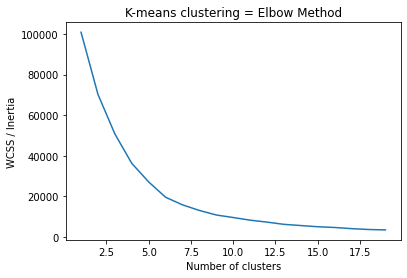

In [ ]:
wcss = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeans.fit(result)
    wcss.append(kmeans.inertia_)

# plot the WCSS values for different values of k
plt.plot(range(1, 20), wcss)
plt.title('K-means clustering = Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS / Inertia')
plt.show()

      --> Elbow : 7 clusters seem approprate?

##### B) SILHOUETTE TEST

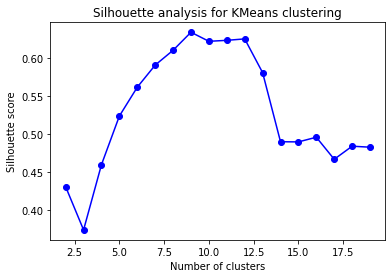

In [ ]:
# specify the range of k values to test
k_range = range(2, 20)

# calculate the silhouette scores for each k value
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(result)
    silhouette_scores.append(silhouette_score(result, cluster_labels))

# plot the silhouette scores as a function of k
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis for KMeans clustering')
plt.show()


      --> Silhouette : 9???

#### 2) HIERARCHICAL CLUSTERING

<Figure size 1800x1200 with 0 Axes>

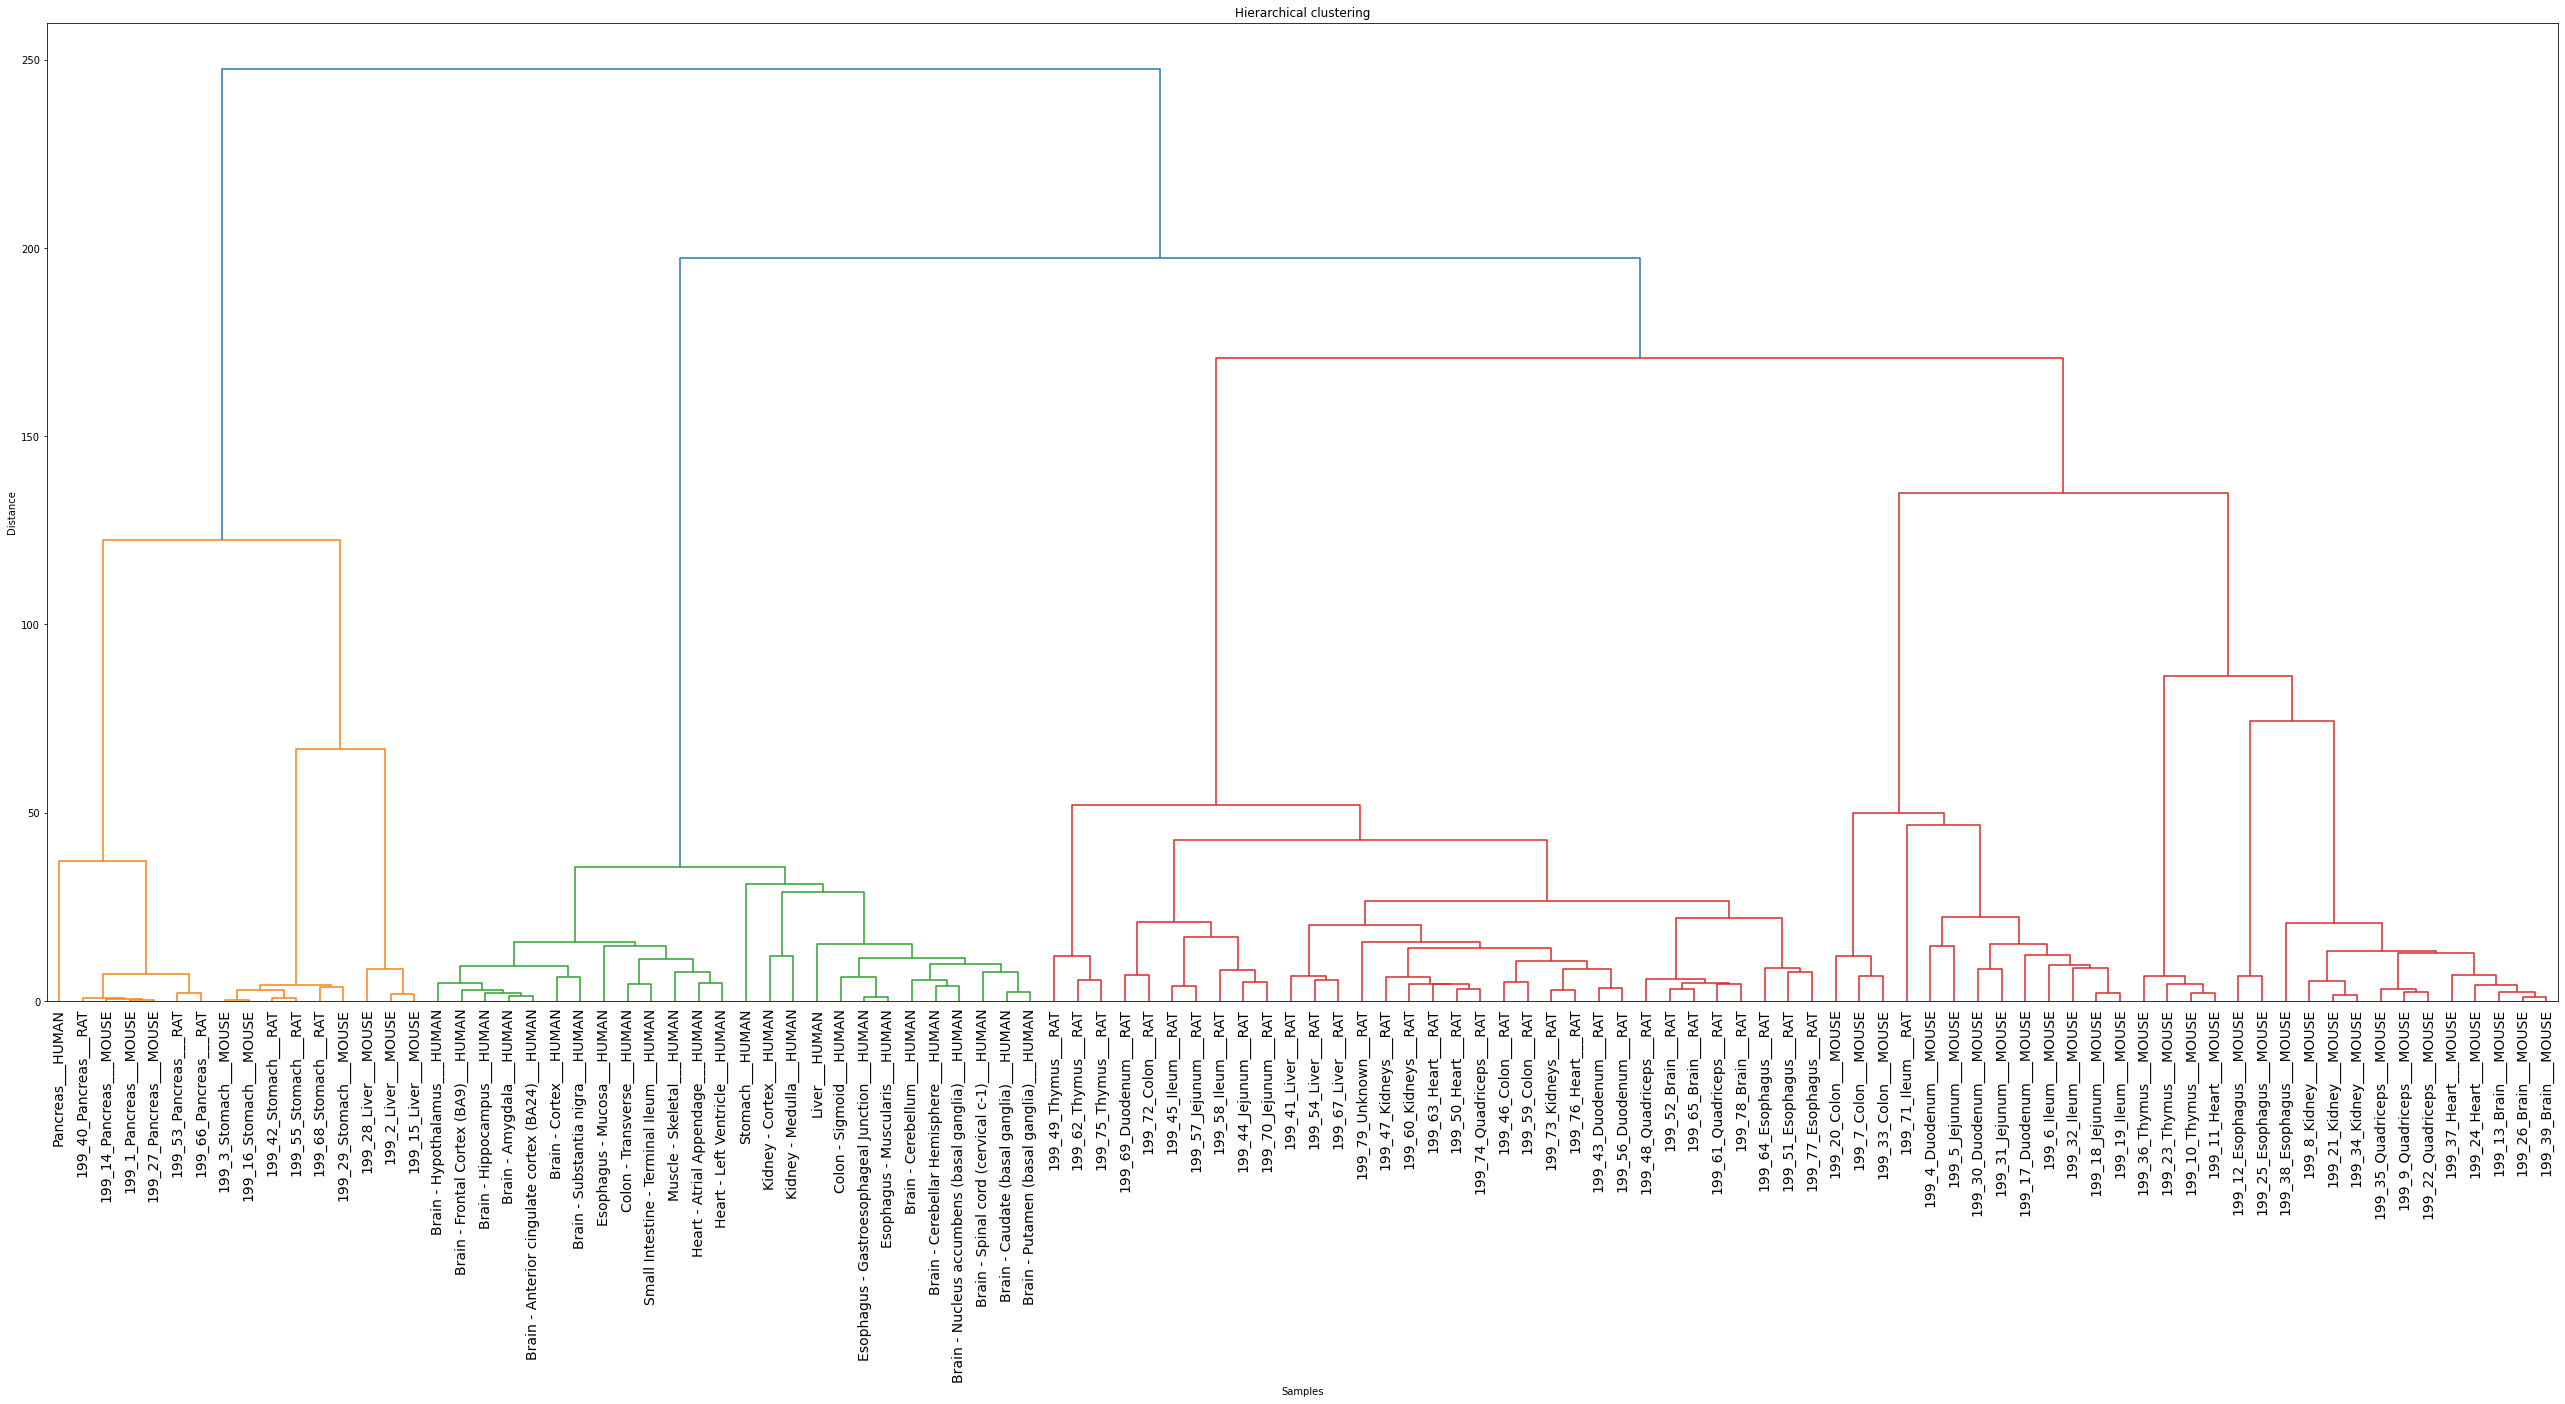

In [ ]:
plt.figure(dpi=300)

Z = linkage(result, method='ward')

# Determine the optimal number of clusters using the dendrogram
plt.figure(figsize=(45, 18))
dendrogram(Z, labels=result.index, leaf_font_size=14)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Hierarchical clustering')
plt.show()

    I don't really know how to read these. 
    Online it says that 'we should draw the lines when the distances
    get too big.' So maybe somewhere aroung 100 on the y-axis? 
    That would be 6 clusters.

#### Let's assume 7 clusters is appropriate

In [ ]:
N_O_C = 7

# Run k-means with the optimal number of clusters
kmeans = KMeans(n_clusters=N_O_C, random_state=0).fit(result)

# Run hierarchical clustering with the optimal number of clusters
hclustering = AgglomerativeClustering(n_clusters=N_O_C, linkage='ward').fit(result)




In [ ]:
# Add the cluster labels to the original dataframe
result['kmeans_cluster'] = kmeans.labels_
# kmeans_test_list = kmeans.labels_

result['hierarchical_cluster'] = hclustering.labels_
# hc_test_list = hclustering.labels_

### Compare the clustering results using both methodologies, and with the tissues/species. Show the results of the final partitions as a table.

In [ ]:
# Calculate the number of tissues in each cluster for both algorithms
kmeans_tissue_counts = result.groupby([result.index.str.split('___').str[1], 'kmeans_cluster']).size().reset_index(name='count')
hierarchical_tissue_counts = result.groupby([result.index.str.split('___').str[1], 'hierarchical_cluster']).size().reset_index(name='count')

# Print the results as tables
print('K-means clustering results:')
display(kmeans_tissue_counts.T)
print('\nHierarchical clustering results:')
display(hierarchical_tissue_counts.T)


K-means clustering results:


,0,1,2,3,4,5,6,7,8,9,10,11
level_0,HUMAN,HUMAN,MOUSE,MOUSE,MOUSE,MOUSE,MOUSE,RAT,RAT,RAT,RAT,RAT
kmeans_cluster,0,2,2,3,4,5,6,1,2,3,5,6
count,26,1,3,6,14,12,4,32,3,3,1,1



Hierarchical clustering results:


,0,1,2,3,4,5,6,7,8,9,10
level_0,HUMAN,HUMAN,MOUSE,MOUSE,MOUSE,MOUSE,MOUSE,RAT,RAT,RAT,RAT
hierarchical_cluster,2,5,0,1,2,4,6,1,2,3,4
count,1,26,14,6,3,12,4,3,3,33,1


In [ ]:
result = result.T

In [ ]:
rez = result.T.drop(columns=['hierarchical_cluster','kmeans_cluster'])
rez = rez.T
rez.drop_duplicates(inplace=True)
rez = rez[~rez.index.duplicated(keep='first')]

### Plot a heatmap of the 50 genes with top variance over all samples. Add the information about tissue groups and model (human, rat and mouse) as annotations in the heatmap*.

In [ ]:
# Calculate the variance of each gene across all samples
gene_variances = rez.var(axis=1)

# Get the indices of the 50 genes with the highest variance
top_variances = gene_variances.nlargest(50).index

# Get a subset of the data with only the top 50 genes
result_top_variances = rez.loc[top_variances]


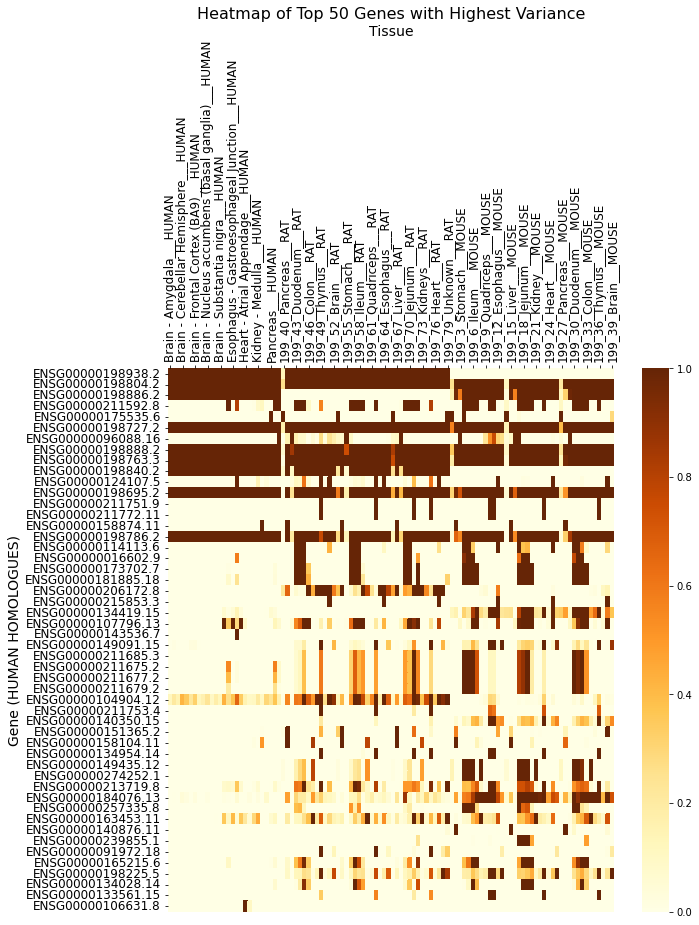

In [ ]:
# Get the tissue and model information from the index
# tissue_info = result_top_variances.index.str.split('_').str[0]
# model_info = result_top_variances.columns.str.split('_').str[1]

# Create a heatmap with the top 50 genes and tissue and model annotations
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(result_top_variances, cmap='YlOrBr', ax=ax, vmin=0, vmax=1)
ax.set_title('Heatmap of Top 50 Genes with Highest Variance', fontsize=16)
ax.set_xlabel('Tissue', fontsize=14)
ax.set_ylabel('Gene (HUMAN HOMOLOGUES)', fontsize=14)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# Exercise 2

## PCA

### With the gene expression for different tissues and models, perform a PCA on the data and visualize the results (PC1 and PC2, and also, PC3 ). Label the points in the plot with their respective tissues/models.

In [ ]:
colors = []
for col_name in result.T.columns:
    if col_name.endswith('___HUMAN'):
        colors.append('red')
    elif col_name.endswith('___RAT'):
        colors.append('blue')
    elif col_name.endswith('___MOUSE'):
        colors.append('green')


handles = [Patch(facecolor='red', label='Human'),
           Patch(facecolor='blue', label='Rat'),
           Patch(facecolor='green', label='Mouse')]


In [ ]:
# Perform PCA on the data
pca = PCA(n_components=3)
pca.fit(result)
result_pca = pca.transform(result)

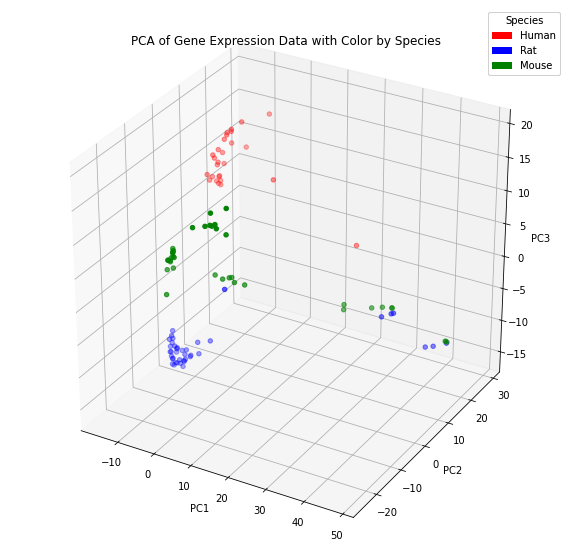

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 1], result_pca[:, 2], c=colors)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of Gene Expression Data with Color by Species')
legend1 = ax.legend(handles=handles, title='Species', loc='upper right')
ax.add_artist(legend1)
plt.show()

### Visualize the data using the PC1 and PC2 again, but this time, color the observations by cluster, using the k means clusters, with k of your choice. Produce a caption for the plot

In [ ]:
# Perform PCA on the data
pca = PCA(n_components=3)
pca.fit(result.T)
result_pca = pca.transform(result.T)

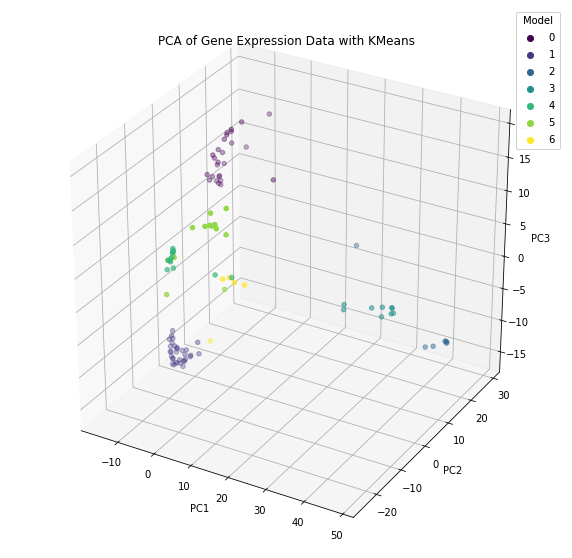

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 1], result_pca[:, 2], c=result.T.kmeans_cluster, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of Gene Expression Data with KMeans')
legend1 = ax.legend(*scatter.legend_elements(), title='Model')
ax.add_artist(legend1)
plt.show()

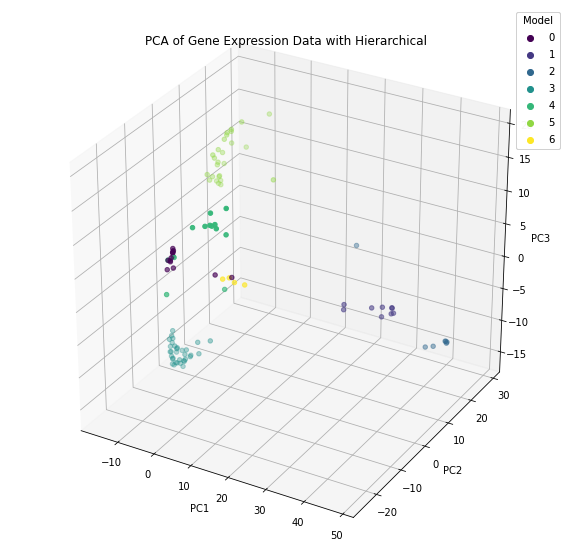

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 1], result_pca[:, 2], c=result.T.hierarchical_cluster, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of Gene Expression Data with Hierarchical')
legend1 = ax.legend(*scatter.legend_elements(), title='Model')
ax.add_artist(legend1)
plt.show()

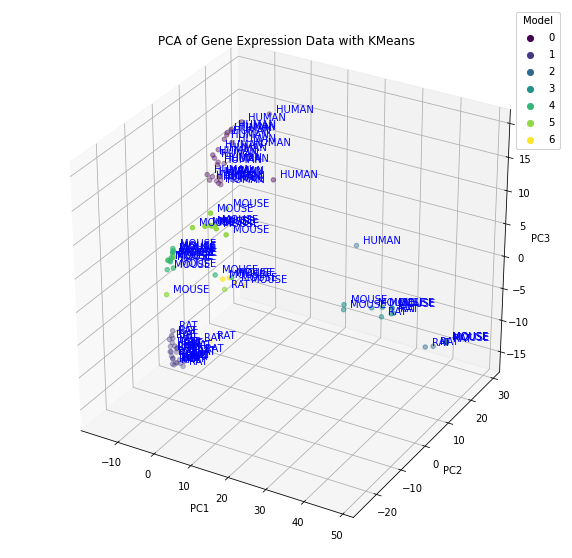

In [ ]:
tissue_model_info = result.columns.str.split('___')
tissue_info = [x[0] for x in tissue_model_info]
model_info = [x[1] for x in tissue_model_info]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 1], result_pca[:, 2], c=result.T.kmeans_cluster, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of Gene Expression Data with KMeans')
legend1 = ax.legend(*scatter.legend_elements(), title='Model')
ax.add_artist(legend1)


# Add labels for each point with offset
for i in range(result_pca.shape[0]):
    tissue = tissue_info[i]
    model = model_info[i]
    ax.text(result_pca[i, 0]+1.05, result_pca[i, 1]+1.05, result_pca[i, 2]+0.05, f'{model}', color='blue')
    # ax.text(result_pca[i, 0]+1.05, result_pca[i, 1]+1.05, result_pca[i, 2]+0.05, f'{tissue}\n{model}', color='black')


plt.show()


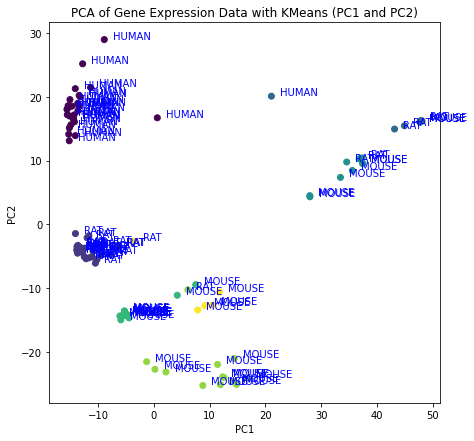

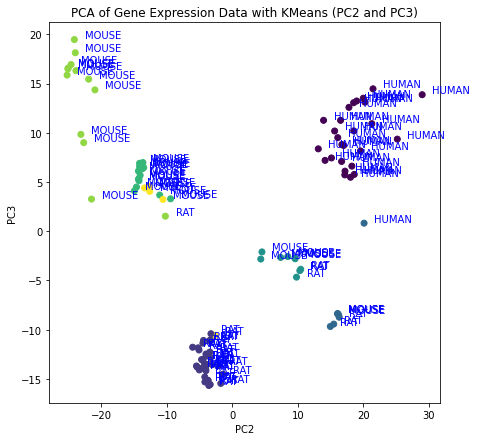

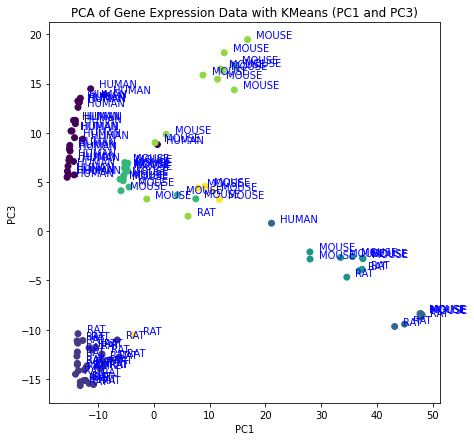

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 1], c=result.T.kmeans_cluster, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA of Gene Expression Data with KMeans (PC1 and PC2)')

# Add labels for each point with offset
for i in range(result_pca.shape[0]):
    tissue = tissue_info[i]
    model = model_info[i]
    ax.text(result_pca[i, 0]+1.55, result_pca[i, 1]+0.15, f'{model}', color='blue')

plt.show()

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(result_pca[:, 1], result_pca[:, 2], c=result.T.kmeans_cluster, cmap='viridis')
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
ax.set_title('PCA of Gene Expression Data with KMeans (PC2 and PC3)')

# Add labels for each point with offset
for i in range(result_pca.shape[0]):
    tissue = tissue_info[i]
    model = model_info[i]
    ax.text(result_pca[i, 1]+1.55, result_pca[i, 2]+0.15, f'{model}', color='blue')

plt.show()


fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 2], c=result.T.kmeans_cluster, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC3')
ax.set_title('PCA of Gene Expression Data with KMeans (PC1 and PC3)')

# Add labels for each point with offset
for i in range(result_pca.shape[0]):
    tissue = tissue_info[i]
    model = model_info[i]
    ax.text(result_pca[i, 0]+1.55, result_pca[i, 2]+0.15, f'{model}', color='blue')

plt.show()



### What are the top 50 genes that contribute to the PC1? Are they the same genes that are more variable according to the exercise 1?

In [ ]:
result = result.T.drop(columns=['hierarchical_cluster','kmeans_cluster'])

In [ ]:
pca = PCA(n_components=3)
pca.fit(result.T)
result_pca = pca.transform(result.T)

In [ ]:
# Get the loadings of the first principal component
loadings_pc1 = pca.components_[0]

# Get the indices of the top 50 genes that contribute to PC1
top_genes_pc1 = np.argsort(np.abs(loadings_pc1))[::-1][:50]

In [ ]:
# Get the names of the top 50 genes
gene_names_pc1 = result.columns[top_genes_pc1]

Index(['ENSG00000116032.5', 'ENSG00000076641.4', 'ENSG00000100104.13',
       'ENSG00000061337.15', 'ENSG00000211950.2', 'ENSG00000117983.17',
       'ENSG00000211950.2', 'ENSG00000139971.15', 'ENSG00000149435.12',
       'ENSG00000256590.2', 'ENSG00000211950.2', 'ENSG00000183304.10',
       'ENSG00000211950.2', 'ENSG00000089012.14', 'ENSG00000211950.2',
       'ENSG00000089012.14', 'ENSG00000198886.2', 'ENSG00000125363.14',
       'ENSG00000211950.2', 'ENSG00000089012.14', 'ENSG00000040731.10',
       'ENSG00000089012.14', 'ENSG00000089012.14', 'ENSG00000198786.2',
       'ENSG00000089012.14', 'ENSG00000209480.1', 'ENSG00000198888.2',
       'ENSG00000183304.10', 'ENSG00000198695.2', 'ENSG00000089012.14',
       'ENSG00000198804.2', 'ENSG00000198763.3', 'ENSG00000211950.2',
       'ENSG00000099917.17', 'ENSG00000089012.14', 'ENSG00000167476.10',
       'ENSG00000089012.14', 'ENSG00000198727.2', 'ENSG00000211950.2',
       'ENSG00000031823.14', 'ENSG00000089012.14', 'ENSG00000211950.2'

In [ ]:
# Get a subset of the data with only the top 50 genes
result_top_variances = rez.loc[gene_names_pc1]

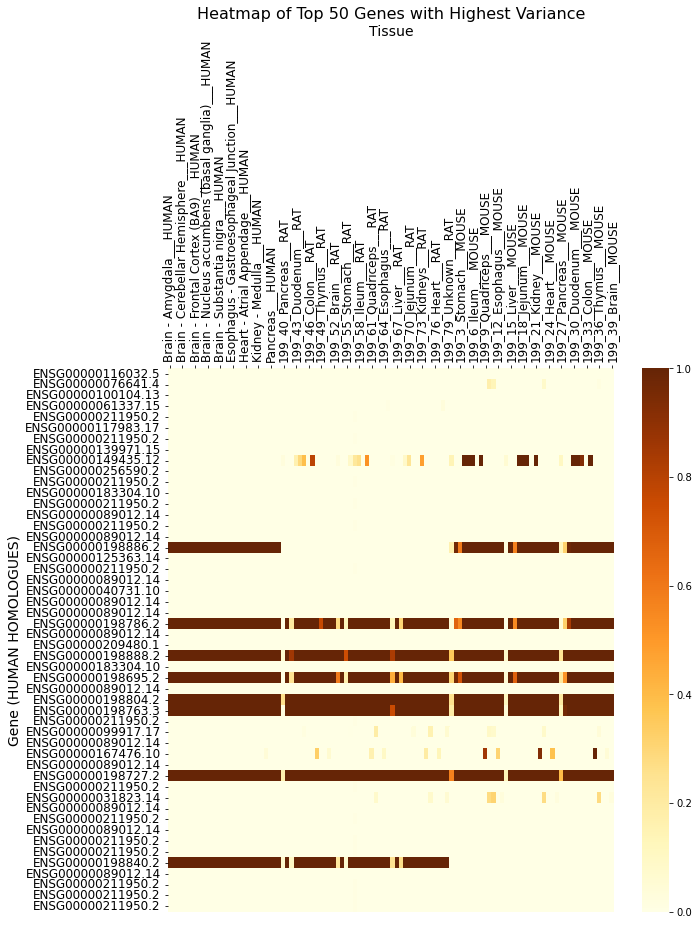

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(result_top_variances, cmap='YlOrBr', ax=ax, vmin=0, vmax=1)
ax.set_title('Heatmap of Top 50 Genes with Highest Variance', fontsize=16)
ax.set_xlabel('Tissue', fontsize=14)
ax.set_ylabel('Gene (HUMAN HOMOLOGUES)', fontsize=14)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
len(top_variances)

50

In [ ]:
len(gene_names_pc1)

50

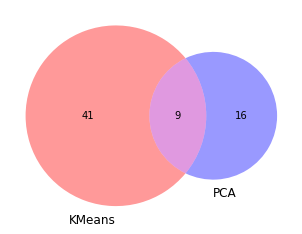

In [ ]:
from matplotlib_venn import venn2

venn2([set(top_variances), set(gene_names_pc1)], set_colors=('red', 'blue'), set_labels=('KMeans', 'PCA'))
plt.show()

######## So there are duplicates in the PCA :( i'll get to that tomorrow

In [ ]:
result

gene_symbol_human,ENSG00000198888.2,ENSG00000198763.3,ENSG00000198804.2,ENSG00000198938.2,ENSG00000198840.2,ENSG00000198886.2,ENSG00000198786.2,ENSG00000198695.2,ENSG00000198727.2,ENSG00000099917.17,...,ENSG00000237700.2,ENSG00000237700.2,ENSG00000237700.2,ENSG00000237700.2,ENSG00000188610.12,ENSG00000184163.3,ENSG00000069812.11,ENSG00000207607.3,kmeans_cluster,hierarchical_cluster
Brain - Amygdala___HUMAN,16.607132,15.650764,29.181921,30.143125,10.435678,23.407355,3.755064,3.965586,13.679369,-0.041229,...,-0.049899,-0.049899,-0.049899,-0.049899,-0.049833,-0.049571,-0.049895,-0.049899,0,5
Brain - Anterior cingulate cortex (BA24)___HUMAN,16.777064,15.579958,29.332556,29.988030,10.553406,23.995905,3.672880,3.631004,12.495571,-0.039519,...,-0.051201,-0.051201,-0.051201,-0.051201,-0.051113,-0.050791,-0.051197,-0.051201,0,5
Brain - Caudate (basal ganglia)___HUMAN,17.590367,22.064078,23.202368,24.809837,12.462099,25.303195,5.163412,5.251103,18.811743,-0.042578,...,-0.053055,-0.053055,-0.053055,-0.053055,-0.052985,-0.052815,-0.053052,-0.053055,0,5
Brain - Cerebellar Hemisphere___HUMAN,17.438761,17.618670,21.534514,30.076040,12.161945,26.728552,3.691008,3.711596,16.640601,-0.027662,...,-0.060761,-0.060761,-0.060761,-0.060761,-0.059709,-0.058988,-0.060753,-0.060761,0,5
Brain - Cerebellum___HUMAN,20.460149,17.996157,21.035033,26.802783,10.677795,27.798758,4.212387,3.815251,18.122733,-0.026536,...,-0.059369,-0.059369,-0.059369,-0.059369,-0.058520,-0.057755,-0.059356,-0.059369,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199_35_Quadriceps___MOUSE,27.931650,20.170307,29.459439,-0.070885,-0.066550,8.424742,8.652870,11.223645,28.060298,-0.058014,...,-0.070885,-0.056398,-0.070885,-0.070885,-0.069508,-0.021077,-0.070885,-0.070885,4,0
199_36_Thymus___MOUSE,13.035499,7.887676,19.830057,-0.234378,-0.232942,5.326413,3.705215,6.299678,21.086142,0.040467,...,-0.234137,-0.120758,-0.234378,-0.234378,-0.188512,-0.152129,-0.234182,-0.234378,6,6
199_37_Heart___MOUSE,22.131009,18.853472,33.184562,-0.052284,-0.048716,8.706851,12.130556,15.745288,27.137636,-0.044130,...,-0.052284,-0.047481,-0.052284,-0.052284,-0.051698,-0.046610,-0.052284,-0.052284,4,0
199_38_Esophagus___MOUSE,18.217152,19.252961,29.256450,-0.083663,-0.082092,9.395027,8.297277,10.633951,33.686954,-0.046380,...,-0.083663,-0.066435,-0.083663,-0.083663,-0.081417,0.006334,-0.082796,-0.083663,4,0


## tSNE

### Perform t-SNE on the dataset and visualize the results. Test at least 2 perplexity values.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


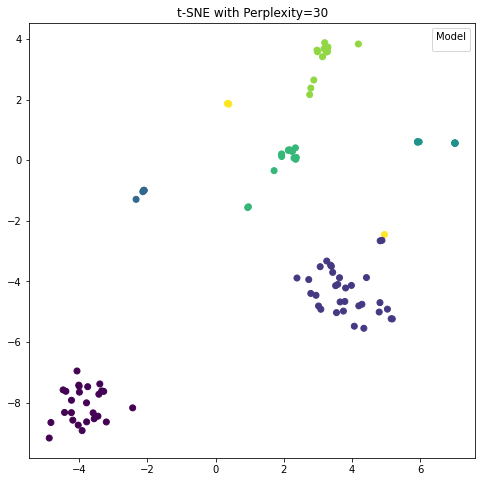

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


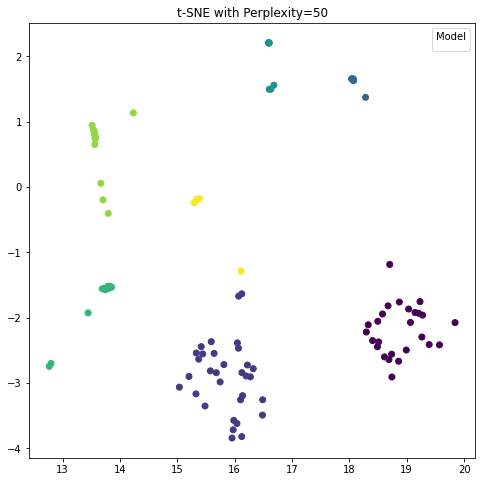

In [ ]:
from sklearn.manifold import TSNE

# Perform t-SNE with perplexity=30
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
result_tsne_30 = tsne.fit_transform(result)

# Plot the results with perplexity=30
plt.figure(figsize=(8, 8))
plt.scatter(result_tsne_30[:, 0], result_tsne_30[:, 1], c=result.kmeans_cluster, cmap='viridis')
plt.title('t-SNE with Perplexity=30')
plt.legend(*scatter.legend_elements(), title='Model', loc='upper right')
plt.show()

# Perform t-SNE with perplexity=50
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
result_tsne_50 = tsne.fit_transform(result)

# Plot the results with perplexity=50
plt.figure(figsize=(8, 8))
plt.scatter(result_tsne_50[:, 0], result_tsne_50[:, 1], c=result.kmeans_cluster, cmap='viridis')
plt.title('t-SNE with Perplexity=50')
plt.legend(*scatter.legend_elements(), title='Model', loc='upper right')
plt.show()

    ########### Here i need to fix the 'Model' legend